In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Enable mixed precision for Apple Silicon
tf.keras.mixed_precision.set_global_policy('mixed_float16')

def image_directory_to_pandas(image_path):
    """
    Create a pandas DataFrame with image paths and taxonomic labels extracted from a directory structure.

    Parameters:
    ----------
    image_path : str
        The root directory containing subfolders with images.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing image paths and label information. Columns include:
        - 'path': The full path to the image.
        - 'folder_label': The folder name, representing the original label (format: 'family_genus_species').
        - 'family': Extracted family name from the folder label.
        - 'genus': Extracted genus name from the folder label.
        - 'species': Combination of genus and species names (e.g., 'genus species').

    Raises:
    ------
    ValueError:
        If the folder label format does not match the expected 'family_genus_species' format.
    """
    labels = []
    paths = []

    # Walk through the directory and collect image paths and labels
    for root_dir, _, filenames in os.walk(image_path):
        for filename in filenames:
            # Ignore hidden files and non-image files
            if filename.startswith('.') or os.path.splitext(filename)[1].lower() not in {".jpeg", ".png", ".jpg"}:
                continue

            # Extract the folder name as the label, ignoring 'GT' directories
            folder_label = os.path.basename(root_dir)
            if folder_label != "GT":
                labels.append(folder_label)
                paths.append(os.path.join(root_dir, filename))

    # Create DataFrame with paths and folder labels
    df = pd.DataFrame({'image_path': paths, 'folder_label': labels})
    df['folder_label'] = df['folder_label'].astype("category")

    # Split the folder_label into 'family', 'genus', and 'species'
    try:
        df[['family', 'genus', 'species']] = df['folder_label'].str.split("_", expand=True)
        df['species'] = df['genus'] + " " + df['species']
    except ValueError as e:
        raise ValueError(
            "Error splitting folder labels. Ensure that your folder structure follows 'family_genus_species' format."
        ) from e

    # Return the dataframe with specified columns
    return df[['image_path', 'folder_label', 'family', 'genus', 'species']]

def split_image_dataframe(df, test_size=0.2, val_size=0.1, random_state=42, stratify_by='folder_label'):
    """
    Split a pandas DataFrame into train, validation, and test sets,
    stratified by the 'folder_name' column.

    Args:
        df (pd.DataFrame): The DataFrame containing image paths and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        random_state (int): Seed for random number generation for reproducibility.

    Returns:
        tuple: Three pandas DataFrames for train, validation, and test sets.
    """
    # First, split into train+validation and test sets
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[stratify_by],
        random_state=random_state
    )
    
    # Calculate the adjusted validation size relative to the remaining train+val data
    val_relative_size = val_size / (1 - test_size)
    
    # Split the train+validation set into train and validation sets
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df[stratify_by],
        random_state=random_state
    )
    
    return train_df, val_df, test_df

def process_image_and_labels(image_path, family, genus, species, family_labels, genus_labels, species_labels, image_size=(224,224)):
    """
    Process an image and its corresponding labels for training.

    Parameters:
    ----------
    image_path : str
        The path to the image file.
    family : str
        The family label of the image.
    genus : str
        The genus label of the image.
    species : str
        The species label of the image.
    family_labels : tf.Tensor
        Tensor of unique family labels.
    genus_labels : tf.Tensor
        Tensor of unique genus labels.
    species_labels : tf.Tensor
        Tensor of unique species labels.

    Returns:
    -------
    img : tf.Tensor
        The processed image tensor.
    labels : dict
        A dictionary containing one-hot encoded labels for family, genus, and species.
    """
    # Load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    img = tf.image.resize(img, image_size)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset_from_dataframe(df, batch_size=32, image_size=(224,224)):
    """
    Build a TensorFlow dataset from a DataFrame containing image paths and taxonomic labels.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing the following columns:
        - 'path': The path to the image.
        - 'Family': The family label of the image.
        - 'Genus': The genus label of the image.
        - 'Species': The species label of the image.
    batch_size : int, optional
        Batch size for training. Default is 32.

    Returns:
    -------
    image_label_ds : tf.data.Dataset
        A TensorFlow dataset with images and one-hot encoded labels.
    family_labels : list
        A sorted list of unique family labels.
    genus_labels : list
        A sorted list of unique genus labels.
    species_labels : list
        A sorted list of unique species labels.
    """
    # Extract the unique family, genus, and species from the dataframe
    family_labels = sorted(df['family'].unique())
    genus_labels = sorted(df['genus'].unique())
    species_labels = sorted(df['species'].unique())

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Create a TensorFlow dataset from the dataframe's paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(
        (df['image_path'].values, df['family'].values, df['genus'].values, df['species'].values)
    )

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda path, family, genus, species: process_image_and_labels(
            path, family, genus, species, family_labels, genus_labels, species_labels, image_size=image_size
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(df))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    

In [2]:
settings = dict(
    batch_size = 64,
    epochs = 10,
    ftun_epochs = 10,
    img_size = (128, 128),
    seed = 42,
    ftun_last_layers = 70,
    ftune_learning_rate = 0.00001,
    
)

PARAMS = {
    "val_size":0.15,
    "test_size": 0.15,
    "random_state": 42,
    "stratify_by": "folder_label",
    "data_aug":{
        "flip": 'horizontal',
        "rotation": 0.2,
        "zoom": 0.2,
        "translation": (0.1, 0.1),
        "contrast": 0.2,
        "brightness": 0.2,
    },
    "img_size": (128, 128),
    "batch_size": 64,
    "model":{
      "base_model":'ResNet50V2',
      "base_model_short": 'rn50v2',
      "weights": 'imagenet',
      "trainable": False,
      "dropout": 0.2,
      "unfreeze_layers": False,
      "shared_layer": 2048,
      "family_transform": 256,
      "family_attention": 2048,
      "genus_transform": 256,
      "genus_residual": 256,
      "genus_attention": 2048,
      "species_transform": 256,
      "species_residual": 256,
      "loss": "categorical_crossentropy",
      "metrics": ["accuracy", "AUC", "Precision", "Recall"],
      "epochs": 10,
      'learning_rate': 0.0001,
      "ftun_last_layers": 70,
      "ftun_learning_rate": 0.00001,
      "ftun_epochs": 10,
    },
    "verbose":1,
}

df = image_directory_to_pandas("/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset")

train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

# Display the sizes of each split
print(f"Training Sample size: {len(train_df)}")
print(f"Validation Sample size: {len(val_df)}")
print(f"Test Sample size: {len(test_df)}")

train_ds, family_labels, genus_labels, species_labels = build_dataset_from_dataframe(train_df, settings['batch_size'], settings['img_size'])  
val_ds, _, _, _ = build_dataset_from_dataframe(val_df, settings['batch_size'], settings['img_size'])
test_ds, _, _, _ = build_dataset_from_dataframe(test_df, settings['batch_size'], settings['img_size'])

Training Sample size: 6315
Validation Sample size: 1354
Test Sample size: 1354


2024-10-30 13:53:01.910451: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-30 13:53:01.910480: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-30 13:53:01.910485: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-30 13:53:01.910498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 13:53:01.910508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Image shape: (64, 128, 128, 3)


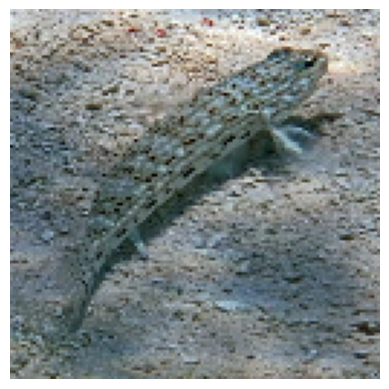

Family Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Genus Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Species Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
# Retrieve a single batch from train_ds
sample = next(iter(train_ds))
sample_image, sample_labels = sample  # Extract the image and label components

# Display the shape and type of each component to understand the structure
print("Image shape:", sample_image.shape)
#print("Labels:", sample_labels)

# If you want to display the image and see its labels
import matplotlib.pyplot as plt

# Display the first image in the batch
plt.imshow(sample_image[0].numpy().astype("uint16"))
plt.axis('off')
plt.show()

# Print out the labels for the first image
print("Family Label:", sample_labels['family'][0].numpy())
print("Genus Label:", sample_labels['genus'][0].numpy())
print("Species Label:", sample_labels['species'][0].numpy())

In [4]:
import pandas as pd
from collections import defaultdict

def create_taxonomic_mappings(df):
    """
    Generate genus_to_family and species_to_genus mappings based on the alphabetical order 
    of the family, genus, and species labels.
    
    Args:
    - df (pd.DataFrame): A DataFrame containing columns 'family', 'genus', 'species'.

    Returns:
    - genus_to_family (dict): Mapping from each genus to its respective family.
    - species_to_genus (dict): Mapping from each species to its respective genus.
    - family_labels (list): Alphabetically ordered list of unique family labels.
    - genus_labels (list): Alphabetically ordered list of unique genus labels.
    - species_labels (list): Alphabetically ordered list of unique species labels.
    """
    # Get unique, sorted labels
    family_labels = sorted(df['family'].unique())
    genus_labels = sorted(df['genus'].unique())
    species_labels = sorted(df['species'].unique())

    # Initialize mappings
    genus_to_family = {}
    species_to_genus = {}

    # Populate the mappings
    for _, row in df.iterrows():
        family = row['family']
        genus = row['genus']
        species = row['species']

        # Map genus to family
        if genus not in genus_to_family:
            genus_to_family[genus] = family

        # Map species to genus
        if species not in species_to_genus:
            species_to_genus[species] = genus

    # Return mappings and sorted label lists
    return genus_to_family, species_to_genus, family_labels, genus_labels, species_labels

# Example usage:
# Assuming 'df' is your DataFrame with columns 'family', 'genus', and 'species'
genus_to_family, species_to_genus, family_labels, genus_labels, species_labels = create_taxonomic_mappings(df)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)


2024-10-30 13:53:12.179519: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


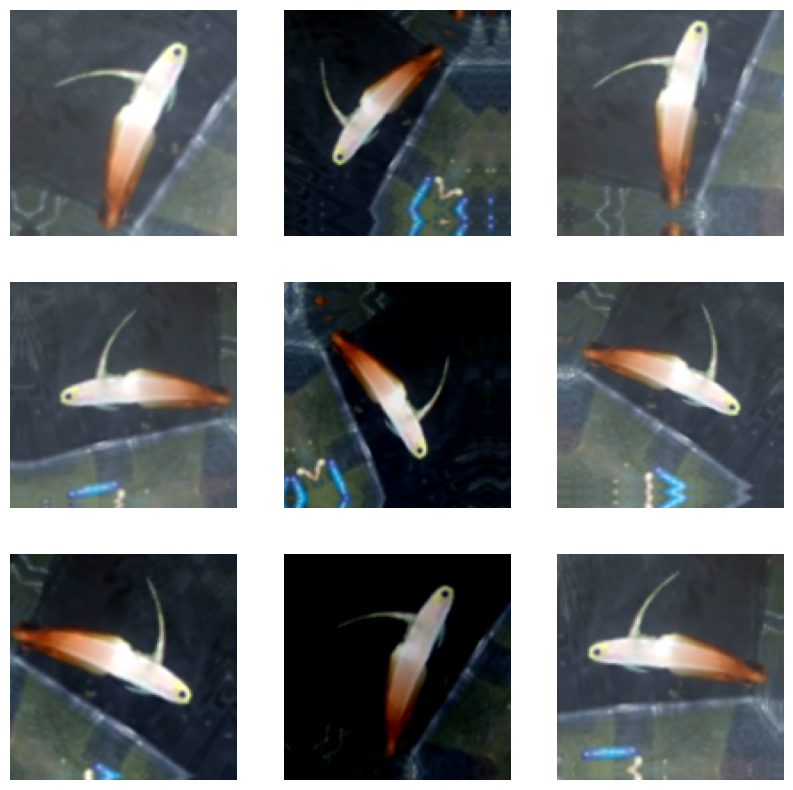

In [7]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0].numpy().astype("uint64"))
    plt.axis('off')

In [8]:
# Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

base_model = tf.keras.applications.ResNet50V2(
    input_shape=settings['img_size'] + (3,),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False

# Define the inputs and apply augmentation
inputs = tf.keras.Input(shape=settings['img_size'] + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Shared dense layer for better feature learning
shared_layer = tf.keras.layers.Dense(512, activation='relu', name='shared_layer')(x)

# Define family output
family_output = tf.keras.layers.Dense(len(family_labels), activation='softmax', name='family')(shared_layer)

# Concatenate the family output with the base model output
family_features = tf.keras.layers.Concatenate()([shared_layer, family_output])

# Define genus output, using family features as additional input
genus_hidden = tf.keras.layers.Dense(256, activation='relu')(family_features)
genus_output = tf.keras.layers.Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

# Concatenate the family and genus outputs with the base model output
genus_features = tf.keras.layers.Concatenate()([shared_layer, family_output, genus_output])

# Define species output, using both family and genus features as additional input
species_hidden = tf.keras.layers.Dense(256, activation='relu')(genus_features)
species_output = tf.keras.layers.Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

# Create the hierarchical model
model = tf.keras.Model(inputs, [family_output, genus_output, species_output])

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow.keras import backend as K

# Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * (alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred))
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# Hierarchical consistency loss
def hierarchical_consistency_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species):
    # Calculate family-level loss
    family_loss = focal_loss()(y_true_family, y_pred_family)
    
    # Genus-level loss with hierarchical penalty based on family misclassification
    genus_loss = focal_loss()(y_true_genus, y_pred_genus)
    genus_penalty = tf.reduce_mean(family_loss) * genus_loss  # Apply penalty if family is wrong
    
    # Species-level loss with penalty based on both family and genus misclassification
    species_loss = focal_loss()(y_true_species, y_pred_species)
    species_penalty = (tf.reduce_mean(family_loss) + tf.reduce_mean(genus_loss)) * species_loss
    
    # Total loss as a combination of focal loss for each level and penalties for hierarchical inconsistency
    return family_loss + genus_penalty + species_penalty

# Final custom loss function combining Focal Loss and Hierarchical Consistency Loss
def combined_hierarchical_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species):
    family_loss = focal_loss()(y_true_family, y_pred_family)
    genus_loss = focal_loss()(y_true_genus, y_pred_genus)
    species_loss = focal_loss()(y_true_species, y_pred_species)
    
    # Hierarchical consistency loss
    hierarchy_loss = hierarchical_consistency_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species)
    
    # Combined loss with hierarchy penalty
    return family_loss + genus_loss + species_loss + 0.1 * hierarchy_loss  # Adjust weighting as needed


In [10]:

# Example usage in model.compile
model.compile(
    optimizer='adam',
    loss={
        'family': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'genus': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'species': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
    },
    metrics = {
                'family': PARAMS['model']['metrics'],
                'genus': PARAMS['model']['metrics'],
                'species': PARAMS['model']['metrics'],
            },
    loss_weights={
        'family': 1.0,
        'genus': 0.8,
        'species': 0.6
    },
)

# Run evaluation
results = model.evaluate(test_ds, return_dict=True)
print(f"""
    -- Simplified Model Report --
    Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}
    Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}
    Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}
""")

2024-10-30 13:53:14.580147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - family_AUC: 0.5158 - family_Precision: 0.0332 - family_Recall: 0.0076 - family_accuracy: 0.0454 - family_loss: 3.6164 - genus_AUC: 0.4845 - genus_Precision: 0.0000e+00 - genus_Recall: 0.0000e+00 - genus_accuracy: 0.0186 - genus_loss: 3.2861 - loss: 9.5576 - species_AUC: 0.5039 - species_Precision: 0.0000e+00 - species_Recall: 0.0000e+00 - species_accuracy: 0.0309 - species_loss: 2.6538

    -- Simplified Model Report --
    Family Accuracy: 0.049 / Loss: 3.732
    Genus Accuracy: 0.021 / Loss: 3.267
    Species Accuracy: 0.026 / Loss: 2.653



In [11]:
history = model.fit(
    train_ds,
    epochs=settings['epochs'],
    validation_data=val_ds,
    batch_size=settings['batch_size'],
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - family_AUC: 0.7223 - family_Precision: 0.3974 - family_Recall: 0.1996 - family_accuracy: 0.2917 - family_loss: 2.5196 - genus_AUC: 0.6860 - genus_Precision: 0.4331 - genus_Recall: 0.0551 - genus_accuracy: 0.1743 - genus_loss: 2.3331 - loss: 6.7747 - species_AUC: 0.6757 - species_Precision: 0.5080 - species_Recall: 0.0458 - species_accuracy: 0.1560 - species_loss: 1.9217 - val_family_AUC: 0.9649 - val_family_Precision: 0.7797 - val_family_Recall: 0.5044 - val_family_accuracy: 0.6573 - val_family_loss: 0.5633 - val_genus_AUC: 0.9603 - val_genus_Precision: 0.7785 - val_genus_Recall: 0.3323 - val_genus_accuracy: 0.5591 - val_genus_loss: 0.7794 - val_loss: 2.0111 - val_species_AUC: 0.9559 - val_species_Precision: 0.7973 - val_species_Recall: 0.3109 - val_species_accuracy: 0.5414 - val_species_loss: 0.6759
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - family_AUC: 0.9589 - family_Precision: 0.7607 - family_Recall: 0.4914 - family

In [12]:
results = model.evaluate(test_ds, return_dict=True)
print(f"""
    -- Simplified Model Report --
    Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}
    Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}
    Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}
""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - family_AUC: 0.9758 - family_Precision: 0.8287 - family_Recall: 0.6318 - family_accuracy: 0.7524 - family_loss: 0.4299 - genus_AUC: 0.9725 - genus_Precision: 0.8485 - genus_Recall: 0.5901 - genus_accuracy: 0.6883 - genus_loss: 0.5336 - loss: 1.3884 - species_AUC: 0.9755 - species_Precision: 0.8128 - species_Recall: 0.5534 - species_accuracy: 0.6660 - species_loss: 0.4312

    -- Simplified Model Report --
    Family Accuracy: 0.755 / Loss: 0.428
    Genus Accuracy: 0.685 / Loss: 0.574
    Species Accuracy: 0.671 / Loss: 0.441



In [13]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-settings['ftun_last_layers']]:
    layer.trainable = False
    
print(f"Unfreezing the last {settings['ftun_last_layers']} layers")

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=settings['ftune_learning_rate']),
    loss_weights={
        'family': 1.0,
        'genus': 0.8,
        'species': 0.6
    },
    loss={
        'family': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'genus': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'species': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
    },
    metrics = {
                'family': PARAMS['model']['metrics'],
                'genus': PARAMS['model']['metrics'],
                'species': PARAMS['model']['metrics'],
            },
)

Unfreezing the last 70 layers


In [14]:
total_epochs =  settings['epochs'] + settings['ftun_epochs']

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
    batch_size=settings['batch_size'],
)

Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 361ms/step - family_AUC: 0.9606 - family_Precision: 0.8515 - family_Recall: 0.3482 - family_accuracy: 0.6278 - family_loss: 0.6065 - genus_AUC: 0.9626 - genus_Precision: 0.8882 - genus_Recall: 0.2555 - genus_accuracy: 0.5713 - genus_loss: 0.8219 - loss: 2.1004 - species_AUC: 0.9657 - species_Precision: 0.8849 - species_Recall: 0.2411 - species_accuracy: 0.5408 - species_loss: 0.6720 - val_family_AUC: 0.9812 - val_family_Precision: 0.8708 - val_family_Recall: 0.6322 - val_family_accuracy: 0.7600 - val_family_loss: 0.3676 - val_genus_AUC: 0.9809 - val_genus_Precision: 0.8551 - val_genus_Recall: 0.5842 - val_genus_accuracy: 0.7016 - val_genus_loss: 0.4801 - val_loss: 1.2463 - val_species_AUC: 0.9798 - val_species_Precision: 0.8400 - val_species_Recall: 0.5547 - val_species_accuracy: 0.6883 - val_species_loss: 0.4029
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step - family_AUC: 0.9790 - family_Precision: 0.8992 - family_Recall: 0.5045 - fami

In [15]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - family_AUC: 0.9850 - family_Precision: 0.8839 - family_Recall: 0.7286 - family_accuracy: 0.7958 - family_loss: 0.2968 - genus_AUC: 0.9816 - genus_Precision: 0.8608 - genus_Recall: 0.6631 - genus_accuracy: 0.7419 - genus_loss: 0.3856 - loss: 0.9897 - species_AUC: 0.9811 - species_Precision: 0.8538 - species_Recall: 0.6496 - species_accuracy: 0.7290 - species_loss: 0.3075

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.795 / Loss: 0.300

Genus Accuracy: 0.745 / Loss: 0.393

Species Accuracy: 0.736 / Loss: 0.314




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


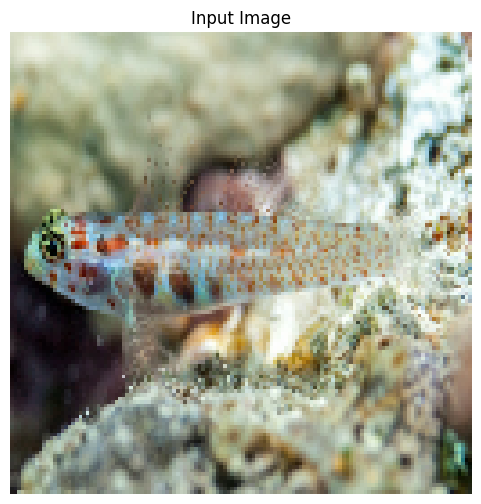

Top 3 Family Predictions:
Gobiidae: 0.4946
Tripterygiidae: 0.3777
Syngnathidae: 0.0433

Top 3 Genus Predictions:
Ucla: 0.3137
Eviota: 0.3054
Istigobius: 0.0649

Top 3 Species Predictions:
Ucla xenogrammus: 0.3767
Eviota albolineata: 0.2085
Eviota melasma: 0.1425


In [17]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset/Gobiidae_Eviota_melasma/web_Eviota_melasma_41.jpeg'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3, image_size=settings['img_size']
)

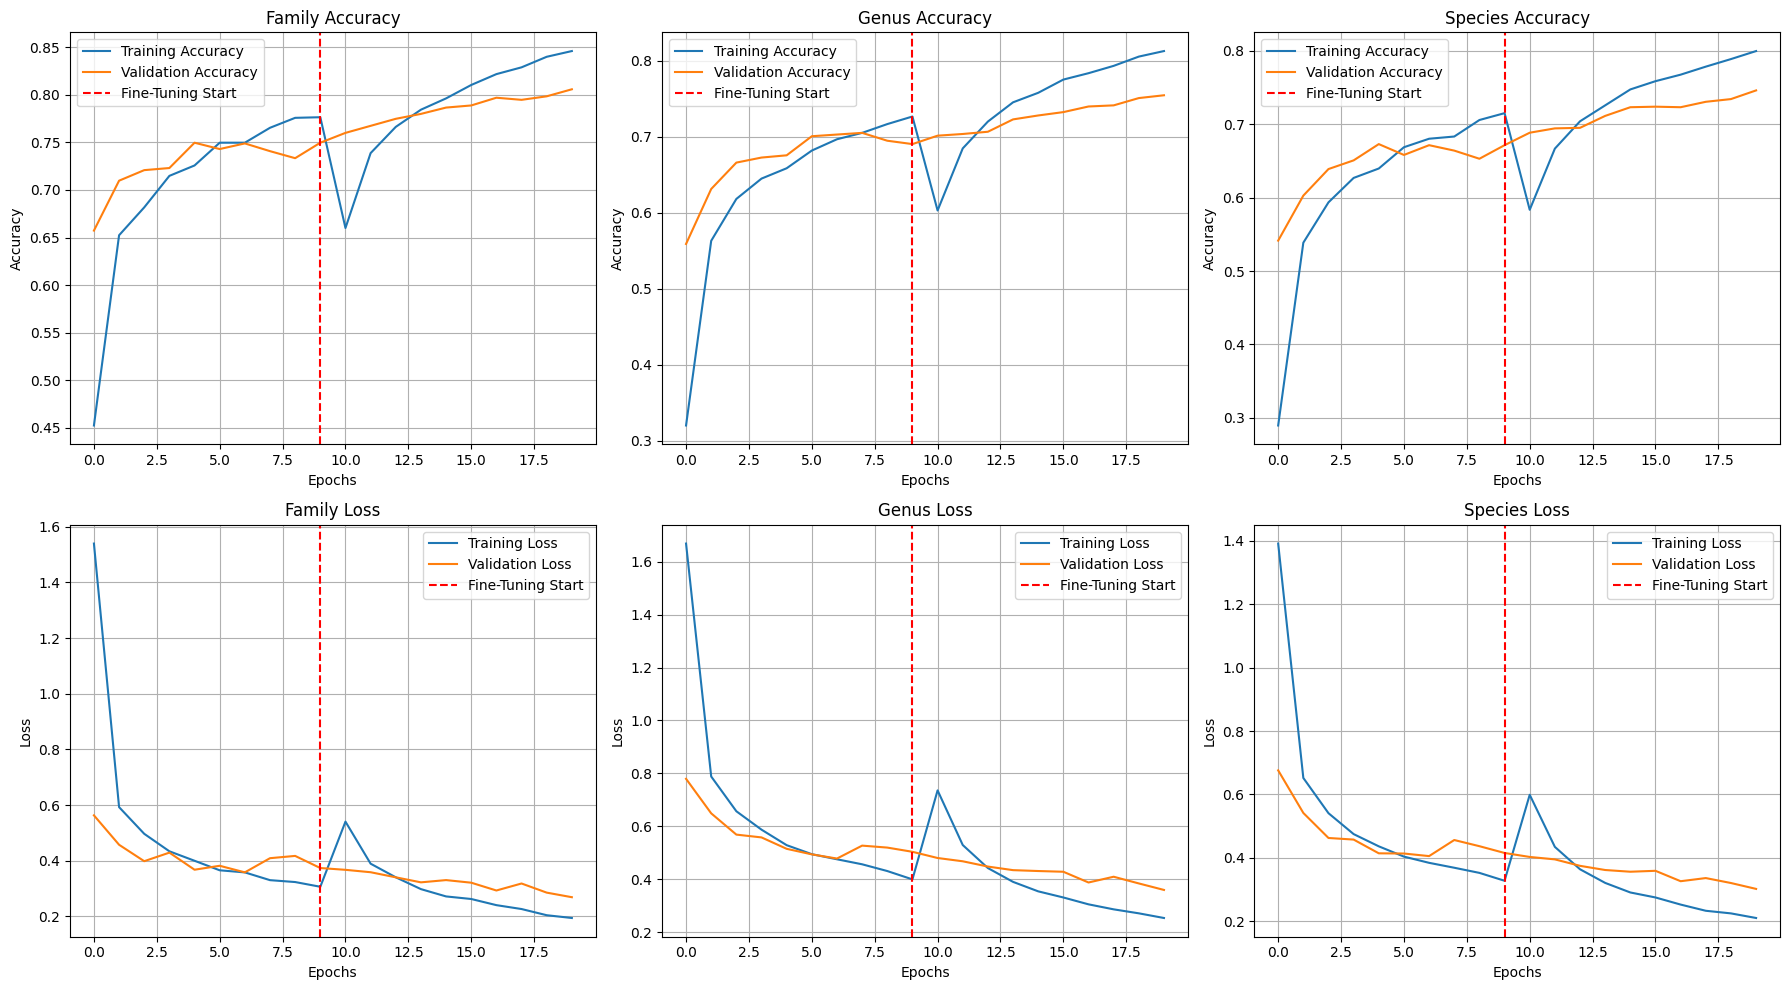

In [18]:
plot_training_history(history, history_fine, fine_tune_at=settings['epochs']-1)

In [19]:
import os
import numpy as np
from collections import defaultdict
import pandas as pd
import tensorflow as tf

def get_taxonomic_mappings_from_folders(data_dir):
    """
    Extract family, genus, and species mappings from the dataset folder structure.
    
    Args:
    - data_dir (str): Path to the training dataset directory.
    
    Returns:
    - family_labels (list): List of unique family names.
    - genus_labels (list): List of unique genus names.
    - species_labels (list): List of unique species names.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    """
    family_labels = set()
    genus_labels = set()
    species_labels = set()
    genus_to_family = {}
    species_to_genus = {}

    # Iterate through the folders in the data directory
    for folder_name in os.listdir(data_dir):
        # Assume folder names are in the format "family_genus_species"
        parts = folder_name.split('_')
        if len(parts) == 3:
            family, genus, species = parts
            family_labels.add(family)
            genus_labels.add(genus)
            species_full = f"{genus}_{species}"
            species_labels.add(species_full)

            # Map genus to family
            genus_to_family[genus] = family

            # Map species to genus
            species_to_genus[species_full] = genus

    # Sort the labels to maintain consistent ordering
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    return family_labels, genus_labels, species_labels, genus_to_family, species_to_genus

def analyze_taxonomic_misclassifications(model, dataset, family_labels, genus_labels, species_labels, genus_to_family, species_to_genus):
    """
    Analyze misclassifications of a trained model to check if taxonomic hierarchies are respected.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Validation or test dataset.
    - family_labels, genus_labels, species_labels (list): List of class labels for family, genus, and species.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    
    Returns:
    - summary (dict): A dictionary containing summary of misclassifications.
    - genus_df (DataFrame): DataFrame with genus misclassification details.
    - species_df (DataFrame): DataFrame with species misclassification details.
    """
    # Counters for misclassifications
    genus_misclassifications = defaultdict(int)
    genus_respect_family = 0
    genus_total_mistakes = 0

    species_misclassifications = defaultdict(int)
    species_respect_genus = 0
    species_respect_family = 0
    species_total_mistakes = 0

    # Iterate over the dataset to collect predictions and true labels
    for images, labels in dataset:
        # Get the logits from the model for each output (family, genus, species)
        family_logits, genus_logits, species_logits = model(images, training=False)

        # Get true and predicted labels for each level
        true_family_indices = tf.argmax(labels['family'], axis=1).numpy()
        true_genus_indices = tf.argmax(labels['genus'], axis=1).numpy()
        true_species_indices = tf.argmax(labels['species'], axis=1).numpy()

        pred_family_indices = np.argmax(family_logits, axis=1)
        pred_genus_indices = np.argmax(genus_logits, axis=1)
        pred_species_indices = np.argmax(species_logits, axis=1)

        # Analyze genus misclassifications
        for true_genus_idx, pred_genus_idx in zip(true_genus_indices, pred_genus_indices):
            if true_genus_idx != pred_genus_idx:
                genus_total_mistakes += 1
                true_genus = genus_labels[true_genus_idx]
                pred_genus = genus_labels[pred_genus_idx]

                # Count the misclassification
                genus_misclassifications[(true_genus, pred_genus)] += 1

                # Check if the misclassified genus is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)  # Use .get() in case pred_genus is missing
                if true_family == pred_family:
                    genus_respect_family += 1

        # Analyze species misclassifications
        for true_species_idx, pred_species_idx in zip(true_species_indices, pred_species_indices):
            if true_species_idx != pred_species_idx:
                species_total_mistakes += 1
                true_species = species_labels[true_species_idx]
                pred_species = species_labels[pred_species_idx]

                # Count the misclassification
                species_misclassifications[(true_species, pred_species)] += 1

                # Check if the misclassified species is in the same genus
                true_genus = species_to_genus[true_species]
                pred_genus = species_to_genus.get(pred_species, None)
                if true_genus == pred_genus:
                    species_respect_genus += 1

                # Check if the misclassified species is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)
                if true_family == pred_family:
                    species_respect_family += 1

    # Calculate percentages of misclassifications that respect the hierarchy
    genus_hierarchy_respect_pct = (genus_respect_family / genus_total_mistakes) * 100 if genus_total_mistakes > 0 else 0
    species_hierarchy_respect_genus_pct = (species_respect_genus / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0
    species_hierarchy_respect_family_pct = (species_respect_family / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0

    # Create a summary of the analysis
    summary = {
        'genus_total_mistakes': genus_total_mistakes,
        'genus_hierarchy_respect': genus_respect_family,
        'genus_hierarchy_respect_pct': genus_hierarchy_respect_pct,
        'genus_misclassifications': dict(genus_misclassifications),
        'species_total_mistakes': species_total_mistakes,
        'species_hierarchy_respect_genus': species_respect_genus,
        'species_hierarchy_respect_genus_pct': species_hierarchy_respect_genus_pct,
        'species_hierarchy_respect_family': species_respect_family,
        'species_hierarchy_respect_family_pct': species_hierarchy_respect_family_pct,
        'species_misclassifications': dict(species_misclassifications),
    }

    # Convert misclassification dictionaries to DataFrames for better readability
    genus_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in genus_misclassifications.items()],
        columns=['True Genus', 'Predicted Genus', 'Count']
    ).sort_values(by='Count', ascending=False)

    species_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in species_misclassifications.items()],
        columns=['True Species', 'Predicted Species', 'Count']
    ).sort_values(by='Count', ascending=False)

    # Print the summaries
    print(f"Genus Misclassifications: {genus_total_mistakes}")
    print(f"Genus Misclassifications Respecting Family: {genus_respect_family} ({genus_hierarchy_respect_pct:.2f}%)")
    print(f"\nTop Genus Misclassifications:\n{genus_df.head(10)}")

    print(f"\nSpecies Misclassifications: {species_total_mistakes}")
    print(f"Species Misclassifications Respecting Genus: {species_respect_genus} ({species_hierarchy_respect_genus_pct:.2f}%)")
    print(f"Species Misclassifications Respecting Family: {species_respect_family} ({species_hierarchy_respect_family_pct:.2f}%)")
    print(f"\nTop Species Misclassifications:\n{species_df.head(10)}")

    return summary, genus_df, species_df

# Example usage:
# Assuming 'train_dir' is the path to the training dataset directory.
train_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
family_labels, genus_labels, species_labels, genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(train_dir)

# Now analyze the misclassifications using the mappings
summary, genus_df, species_df = analyze_taxonomic_misclassifications(
    model=model,
    dataset=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    genus_to_family=genus_to_family,
    species_to_genus=species_to_genus
)

Genus Misclassifications: 344
Genus Misclassifications Respecting Family: 74 (21.51%)

Top Genus Misclassifications:
         True Genus Predicted Genus  Count
15       Fusigobius      Istigobius     11
30   Corythoichthys      Istigobius      8
21       Istigobius      Fusigobius      7
37       Istigobius  Corythoichthys      7
3              Ucla  Enneapterygius      5
68        Gomphosus    Canthigaster      5
101  Corythoichthys      Fusigobius      5
51   Corythoichthys    Canthigaster      4
53            Cypho      Centropyge      4
27           Eviota            Ucla      4

Species Misclassifications: 357
Species Misclassifications Respecting Genus: 27 (7.56%)
Species Misclassifications Respecting Family: 97 (27.17%)

Top Species Misclassifications:
                      True Species              Predicted Species  Count
11            Fusigobius_neophytus           Istigobius_decoratus     10
37   Corythoichthys_flavofasciatus           Istigobius_decoratus      9
40         

2024-10-30 14:14:12.465176: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
from sklearn.metrics import classification_report
# Run predictions on the test dataset and collect true and predicted labels for classification reports
def evaluate_model_classification_report(model, test_ds, family_labels, genus_labels, species_labels):
    true_family, true_genus, true_species = [], [], []
    pred_family, pred_genus, pred_species = [], [], []

    # Iterate over the test dataset and collect true and predicted labels
    for images, labels in test_ds:
        # Get model predictions
        family_preds, genus_preds, species_preds = model(images, training=False)

        # Extract the true labels (one-hot encoded)
        true_family.extend(tf.argmax(labels['family'], axis=1).numpy())
        true_genus.extend(tf.argmax(labels['genus'], axis=1).numpy())
        true_species.extend(tf.argmax(labels['species'], axis=1).numpy())

        # Extract the predicted labels
        pred_family.extend(tf.argmax(family_preds, axis=1).numpy())
        pred_genus.extend(tf.argmax(genus_preds, axis=1).numpy())
        pred_species.extend(tf.argmax(species_preds, axis=1).numpy())

    # Generate classification reports
    family_report = classification_report(true_family, pred_family, target_names=family_labels)
    genus_report = classification_report(true_genus, pred_genus, target_names=genus_labels)
    species_report = classification_report(true_species, pred_species, target_names=species_labels)

    print("Family Classification Report:\n", family_report)
    print("Genus Classification Report:\n", genus_report)
    print("Species Classification Report:\n", species_report)

# Example usage:
evaluate_model_classification_report(model, test_ds, family_labels, genus_labels, species_labels)

Family Classification Report:
                  precision    recall  f1-score   support

     Apogonidae       0.88      0.88      0.88       110
     Blenniidae       0.58      0.55      0.57        51
   Chaenopsidae       0.83      0.38      0.53        13
 Chaetodontidae       0.91      0.92      0.92        53
    Cirrhitidae       0.84      0.89      0.86        36
     Creediidae       1.00      0.50      0.67         8
       Gobiidae       0.80      0.82      0.81       391
       Labridae       0.81      0.87      0.84       143
    Plesiopidae       0.79      0.79      0.79        14
  Pomacanthidae       0.86      0.95      0.91        86
  Pomacentridae       0.77      0.83      0.80       111
Pseudochromidae       0.76      0.52      0.62        25
     Sciaenidae       0.86      0.75      0.80         8
   Scorpaenidae       0.95      0.79      0.87        53
     Serranidae       1.00      1.00      1.00        17
   Syngnathidae       0.76      0.63      0.69        87